In [2]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate_toy as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
sys.path.append('../')
sys.path.append('../../code_Boyle')
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID_toy as model
reload(model)

<module 'read_model_ID_toy' from 'read_model_ID_toy.pyc'>

## Load data

In [35]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../../data_nucleaseq_Finkelsteinlab/targetE/'

xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../../Data_Boyle/',path_to_data,True,False,True)
_, ydatafull, yerrfull = processing.prepare_multiprocessing_combined('1',filename,'../../Data_Boyle/',path_to_data,False)

filename_daba = 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-20.csv'
path_to_data_daba = '../../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

_, ydata_daba, yerr_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,False)
_, ydatawa_daba, yerrwa_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,True)

_, ydata_aba, yerr_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,False)
_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

kclv = []
kon = []
erron = []
aba = []
daba = []
i = 1
while i < 20+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0][0])
            kon.append((ydata[a][1][0]))
            aba.append((ydatawa_aba[a][1][0]))
            daba.append((ydatawa_daba[a][1][0]))
            erron.append((yerr[a][1][0]))
            i = i + 1
    
kclv.append(ydata[0][0][0])
kclv = np.array(kclv)
kon.append((ydata[0][1][0]))
kon = np.array(kon)
aba.append((ydatawa_aba[0][1][0]))
aba = np.array(aba)
daba.append(0.0)
daba = np.array(daba)
erron.append(yerr[0][1][0])
erron = np.array(erron)


k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
aba_double = np.zeros([20,20])
daba_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0][0])
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]
        daba_double[j-1,i-1] = ydatawa_daba[a][1][0]
        if len(ydata[a][1])>0:
            on_double[j-1,i-1] = (ydata[a][1][0])
        else:
            on_double[j-1,i-1] = np.nan
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
on_double_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
aba_double_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))
daba_double_df = pd.DataFrame(daba_double, index=range(1, 21), columns=range(1, 21))

## Load model

In [64]:
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '26' #use for cleavage fit
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '28'
#model_id = 'six_state_model_clv_constant_ei+six_state_model_on_constant_ei';parnum= '10'
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'
#model_id = 'four_state_model_clv_engineered_cas'; parnum = '2'
#model_id = 'four_state_model_clv_rates_constant_ei+four_state_model_on_rates_constant_ei'; parnum = '8'
#model_id = 'four_state_model_clv_rates_constant_ei+four_state_model_on_rates_constant_ei_fixPAM'; parnum = '7'
#model_id = 'engineered_clv_rates_constant_ei+engineered_on_rates_constant_ei'; parnum = '3'
#model_id = 'engineered_clv_rates_constant_ei_v2+engineered_on_rates_constant_ei_v2'; parnum = '4'


filename = 'fit_6_8_2019_sim_5.txt'
path = '../../fits_Stijn/6_8_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
parameters = np.array(final_par.values)

#c = 4.75
#parameters[0] = parameters[0] - np.log(c)
#parameters[-4] = parameters[-4] + np.log10(c)


#parameters[0] = 6.69459452401
#parameters[1] = -0.09948923081260001
#parameters[2] = -0.3

#parameters[1] += 3.
#print parameters
#parameters = np.append(np.append([1.4],parameters[:-2]),np.append([-2.4],parameters[-2:])) #use for cleavage fit

## Plots

OT-ABA: [2.55343307]


Text(453.236,0.5,'mismatch 2')

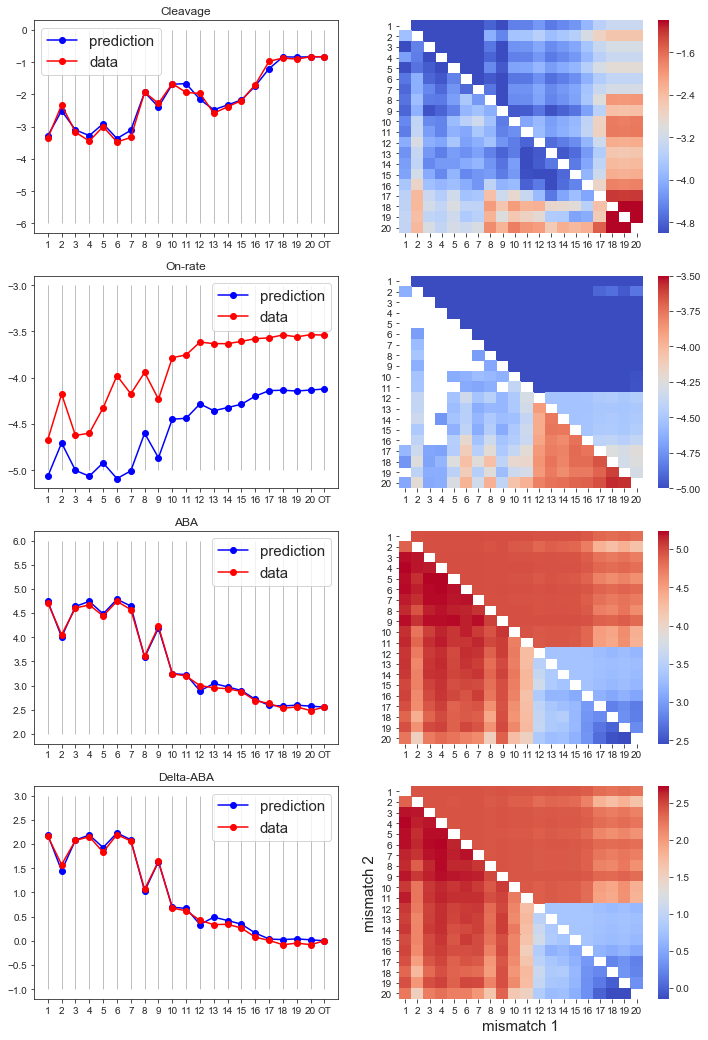

In [65]:
reload(clv)

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair
_,otaba = clv.calc_clv_aba(parameters,model_id,[],conc,ref)
print 'OT-ABA: ' + str(otaba)

k = np.zeros(21)
on = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    k[i-1],on[i-1] = np.log10(clv.calc_clv_on(parameters,model_id,mismatch_positions))
k[-1],on[-1] = np.log10(clv.calc_clv_on(parameters,model_id,[]))

abafit = np.zeros(21)
dabafit = np.zeros(21)
for i in range(1,21):
    mismatch_positions = [i]
    _,abafit[i-1] = clv.calc_clv_aba(parameters,model_id,mismatch_positions,conc,ref)
    dabafit[i-1] = abafit[i-1] - otaba
abafit[-1] = otaba
dabafit[-1] = 0.

f,ax = plt.subplots(4,2,sharey=False,figsize=[12,18])
    
ax[0][0].plot(range(1,22),k,marker='o',color='blue')
ax[0][0].set_xticks(range(1,22));
ax[0][0].set_xticklabels(range(1,21)+['OT'])
ax[0][0].vlines(range(1,22),-6,0,linewidth=0.5,color='grey')
ax[0][0].plot(range(1,22),kclv,marker='o',color='red')
ax[0][0].legend(['prediction','data'],fontsize=15)
ax[0][0].set_title('Cleavage')

ax[1][0].plot(range(1,22),on,marker='o',color='blue')
#ax[1][0].errorbar(range(1,22),kon,erron*10,marker='o',color='red')
ax[1][0].set_xticks(range(1,22));
ax[1][0].set_xticklabels(range(1,21)+['OT'])
ax[1][0].vlines(range(1,22),-5,-3,linewidth=0.5,color='grey')
ax[1][0].plot(range(1,22),kon,marker='o',color='red')
ax[1][0].legend(['prediction','data'],fontsize=15)
ax[1][0].set_title('On-rate')
for i in range(21):
    if i+1==6 or i+1==7:
        ax[0][1].plot(i+1,kon[i],marker='X',color='k',markersize=10)

k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_double[i-1][j-1],on_double[i-1][j-1] = np.log10(clv.calc_clv_on(parameters,model_id,mismatch_positions))
        
k_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
k_df = k_df + k_double_df
for i in range(1,21):
    k_df[i].loc[i]=np.nan
    
on_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
on_df = on_df + on_double_df
for i in range(1,21):
    on_df[i].loc[i]=np.nan
    
    
aba_double = np.zeros([20,20])
daba_double = np.zeros([20,20])
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        _,aba_double[i-1][j-1] = clv.calc_clv_aba(parameters,model_id,mismatch_positions,conc,ref)
        daba_double[i-1][j-1] = aba_double[i-1][j-1] - otaba
        
aba_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))
aba_df = aba_df + aba_double_df
for i in range(1,21):
    aba_df[i].loc[i]=np.nan
    
daba_df = pd.DataFrame(daba_double, index=range(1, 21), columns=range(1, 21))
daba_df = daba_df + daba_double_df
for i in range(1,21):
    daba_df[i].loc[i]=np.nan
    
sns.heatmap(k_df, cmap='coolwarm', cbar=True,ax=ax[0][1],vmin=-5,vmax=-1)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(on_df, cmap='coolwarm', cbar=True,ax=ax[1][1],vmin=-5,vmax=-3.5)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)



ax[2][0].plot(range(1,22),abafit,marker='o',color='blue')
ax[2][0].set_xticks(range(1,22));
ax[2][0].set_xticklabels(range(1,21)+['OT'])
ax[2][0].vlines(range(1,22),2,6,linewidth=0.5,color='grey')
ax[2][0].plot(range(1,22),aba,marker='o',color='red')
ax[2][0].legend(['prediction','data'],fontsize=15)
ax[2][0].set_title('ABA')

ax[3][0].plot(range(1,22),dabafit,marker='o',color='blue')
#ax[3][0].errorbar(range(1,22),kon,erron*10,marker='o',color='red')
ax[3][0].set_xticks(range(1,22));
ax[3][0].set_xticklabels(range(1,21)+['OT'])
ax[3][0].vlines(range(1,22),-1,3,linewidth=0.5,color='grey')
ax[3][0].plot(range(1,22),daba,marker='o',color='red')
ax[3][0].legend(['prediction','data'],fontsize=15)
ax[3][0].set_title('Delta-ABA')

sns.heatmap(aba_df, cmap='coolwarm', cbar=True,ax=ax[2][1])#,vmin=2,vmax=6)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

sns.heatmap(daba_df, cmap='coolwarm', cbar=True,ax=ax[3][1])#,vmin=-1,vmax=3)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)

## Correlation Plots

Text(0,0.5,'Measured ABA (kBT)')

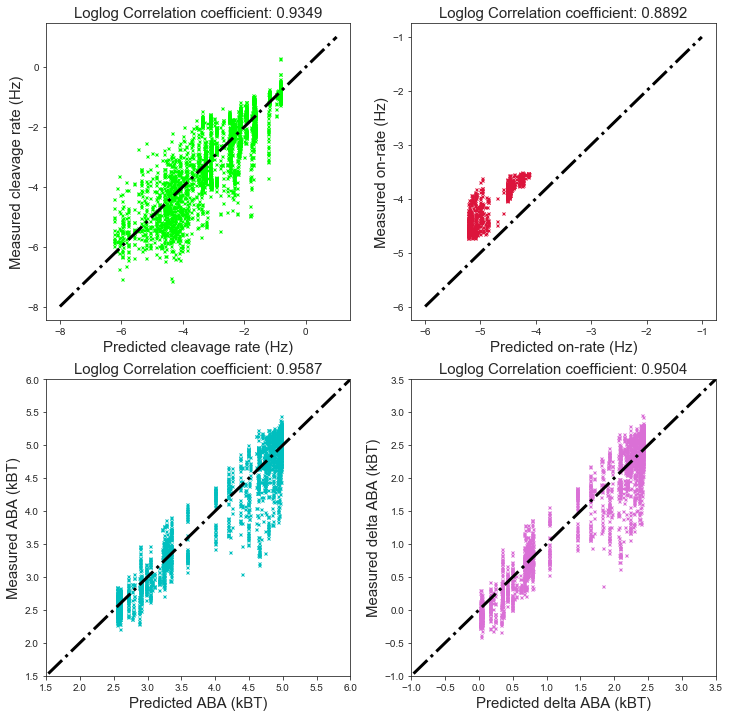

In [66]:
datacleave = []
fitcleave = []
dataon = []
fiton = []
dataaba = []
fitaba = []
datadaba = []
fitdaba = []

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair
_,otaba = clv.calc_clv_aba(parameters,model_id,[],conc,ref)

for i in range(len(xdata)):
    cleavagetemp, ontemp = np.log10(clv.calc_clv_on(parameters,model_id,xdata[i]))
    _, abatemp = clv.calc_clv_aba(parameters,model_id,xdata[i],conc,ref)
    dabatemp = abatemp - otaba
    for j in range(len(ydatafull[i][0])):
        if (ydatafull[i][0][j])>(-10):
            datacleave.append(ydatafull[i][0][j])
            fitcleave.append(cleavagetemp)
    for j in range(len(ydatafull[i][1])):        
        if ydatafull[i][1][j]>(-10):
            dataon.append(np.log10(ydatafull[i][1][j]))
            fiton.append(ontemp)
    for j in range(len(ydata_aba[i][1])):
        dataaba.append(ydata_aba[i][1][j])
        fitaba.append(abatemp)
    for j in range(len(ydata_daba[i][1])):
        datadaba.append(ydata_daba[i][1][j])
        fitdaba.append(dabatemp)
        
f,ax = plt.subplots(2,2,sharey=False,figsize=[12,12])

ax[0][0].plot(fitcleave,datacleave,marker='x',markersize=3,color='lime',linewidth=0.0)
ax[0][0].plot([-8,1],[-8,1],'k-.',linewidth=3)
#ax[0][0].set_axis([-8,1,-8,1])
ax[0][0].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datacleave,fitcleave])[0][1],4)), fontsize=15)
ax[0][0].set_xlabel('Predicted cleavage rate (Hz)',fontsize=15)
ax[0][0].set_ylabel('Measured cleavage rate (Hz)',fontsize=15)

ax[0][1].plot(fiton,dataon,marker='x',markersize=3,color='crimson',linewidth=0.0)
ax[0][1].plot([-6,-1],[-6,-1],'k-.',linewidth=3)
#plt.axis([-8,1,-8,1])
ax[0][1].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([dataon,fiton])[0][1],4)), fontsize=15)
ax[0][1].set_xlabel('Predicted on-rate (Hz)',fontsize=15)
ax[0][1].set_ylabel('Measured on-rate (Hz)',fontsize=15)

ax[1][1].plot(fitdaba,datadaba,marker='x',markersize=3,color='orchid',linewidth=0.0)
ax[1][1].plot([-2,5],[-2,5],'k-.',linewidth=3)
ax[1][1].axis([-1.,3.5,-1.,3.5])
ax[1][1].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([datadaba,fitdaba])[0][1],4)), fontsize=15)
ax[1][1].set_xlabel('Predicted delta ABA (kBT)',fontsize=15)
ax[1][1].set_ylabel('Measured delta ABA (kBT)',fontsize=15)

ax[1][0].plot(fitaba,dataaba,marker='x',markersize=3,color='c',linewidth=0.0)
ax[1][0].plot([-2,7],[-2,7],'k-.',linewidth=3)
ax[1][0].axis([1.5,6.,1.5,6.])
ax[1][0].set_title('Loglog Correlation coefficient: ' + str(np.round(np.corrcoef([dataaba,fitaba])[0][1],4)), fontsize=15)
ax[1][0].set_xlabel('Predicted ABA (kBT)',fontsize=15)
ax[1][0].set_ylabel('Measured ABA (kBT)',fontsize=15)

## Chi-squared evolution

382.812012635


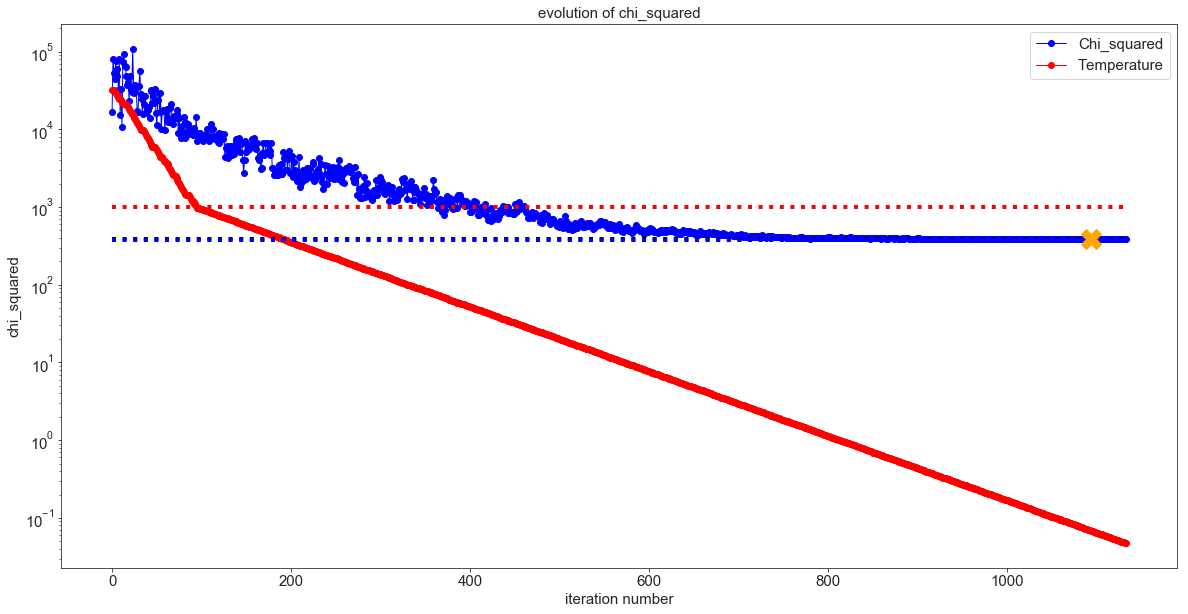

In [67]:
plt.figure(figsize=[20,10])
plt.plot(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(T, marker='o', linewidth=1, color='red')
plt.plot([0,len(chi)],[min(chi),min(chi)],linewidth=4,linestyle=':',color='k')
plt.plot([0,len(chi)],[380,380],linewidth=4,linestyle=':',color='b')
plt.plot([0,len(chi)],[1000,1000],linewidth=4,linestyle=':',color='r')
plt.semilogy(np.argmin(chi),min(chi),marker='X',markersize=20,color='orange')
plt.legend(['Chi_squared','Temperature'],fontsize=15)
print min(chi)

# Looking at batches of fits

In [3]:
simset = []
final_par = []
energies = []
rates = []

chi_squared = []

file = '../../fits_Stijn/6_8_2019/fit_6_8_2019_sim_'
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '26' #use for cleavage fit
#model_id = 'four_state_model_clv+four_state_model_on';parnum = '28'
#model_id = 'six_state_model_clv_constant_ei+six_state_model_on_constant_ei';parnum= '10'
model_id = 'four_state_model_clv_rates+four_state_model_on_rates'; parnum = '27'
#model_id = 'four_state_model_clv_engineered_cas'; parnum = '2'
#model_id = 'four_state_model_clv_rates_constant_ei+four_state_model_on_rates_constant_ei'; parnum = '8'
#model_id = 'four_state_model_clv_rates_constant_ei+four_state_model_on_rates_constant_ei_fixPAM'; parnum = '7'
#model_id = 'engineered_clv_rates_constant_ei+engineered_on_rates_constant_ei'; parnum = '3'
#model_id = 'engineered_clv_rates_constant_ei_v2+engineered_on_rates_constant_ei_v2'; parnum = '4'

#---------- collect simulations ---------------
for sim in range(1,11):
    sa = pd.read_csv(file +str(sim)+'.txt', delimiter='\t', index_col=False)
    filename = file +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
    simset.append(filename)
    final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
    final_par_temp = final_par_temp.values
    
    #final_par_temp = np.append(np.append([1.4],final_par_temp[:-2]),np.append([-2.4],final_par_temp[-2:])) #use for cleavage fit
    id_clv,id_on,para_clv,para_on = model.combined_model(final_par_temp,model_id)
    
    epsilon,ratestemp = model.unpack_parameters(para_on,id_on)
    _,ratesclv = model.unpack_parameters(para_clv,id_clv)
    
    #epsilon,ratestemp = model.unpack_parameters(final_par_temp,model_id)
    #ratesclv = ratestemp
    
    #epsilon[0] *= -1
    
    energies.append(epsilon)
    rates.append(np.append(ratestemp[0:3],ratesclv[-1]))
        
    final_par_temp[0] = -final_par_temp[0]
    final_par.append(final_par_temp)
    
best_fit = simset[np.argmin(chi_squared)]
print 'best fit: ' + best_fit
print 'all chi_squared: ' + str(chi_squared)

C:\Users\stijn\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


best fit: ../../fits_Stijn/6_8_2019/fit_6_8_2019_sim_5.txt
all chi_squared: [1729.48770776, 395.869023749, 402.001339847, 401.464574747, 382.812012635, 1950.02574937, 1886.28498239, 919.934333169, 946.494040115, 988.378375913]


7


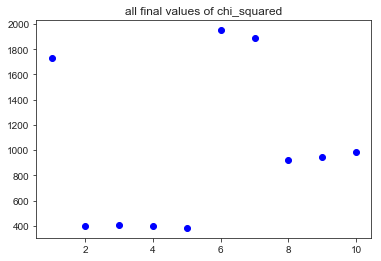

In [5]:
chi_squared = np.array(chi_squared)
indices_low_chi = np.where(chi_squared<1000)
final_par_low_chi = np.array(final_par)[indices_low_chi[0]]
energies_low_chi = np.array(energies)[indices_low_chi[0]]
rates_low_chi = np.array(rates)[indices_low_chi[0]]
low_chi = chi_squared[indices_low_chi[0]]
plt.plot(range(1,len(chi_squared)+1),chi_squared,'bo')
plt.title('all final values of chi_squared')

median = np.zeros(len(final_par_low_chi[0]))
median_energies = np.zeros(len(energies_low_chi[0]))
median_rates = np.zeros(len(rates_low_chi[0]))

for i in range(len(final_par_low_chi[0])):
    median_temp = list()
    for j in range(len(final_par_low_chi)):
        median_temp.append(final_par_low_chi[j][i])
    median[i] = np.median(np.array(median_temp))
    
for i in range(len(energies_low_chi[0])):
    median_temp = list()
    for j in range(len(energies_low_chi)):
        median_temp.append(energies_low_chi[j][i])
    median_energies[i] = np.median(np.array(median_temp))
    
for i in range(len(rates_low_chi[0])):
    median_temp = list()
    for j in range(len(rates_low_chi)):
        median_temp.append(rates_low_chi[j][i])
    median_rates[i] = np.median(np.array(median_temp))
    
print len(final_par_low_chi)

## Energies

[2.68171193 1.55493407 6.52711273]
[2.68426921 1.55465712 6.52913674]
[2.68283272 1.55776942 6.56142399]
[2.67722596 1.62358303 6.40241685]
[2.79381255 1.61495914 7.68934726]
[2.58598658 1.57371126 5.79916994]
[2.77099413 2.07153722 8.56185149]


[0.7, 3.4, -1, 15]

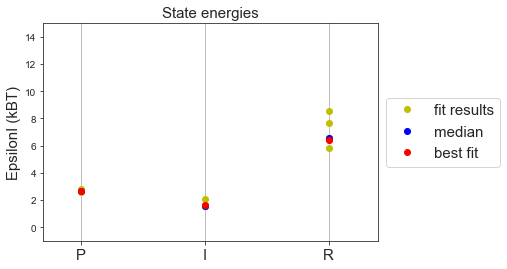

In [6]:
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,4),energies_low_chi[i][0:3],'yo',label='fit results')
    print energies_low_chi[i][0:3]
    
plot2, = plt.plot(range(1,4),median_energies[0:3],'bo',label='median')
plot3, = plt.plot(range(1,4),energies[np.argmin(chi_squared)][0:3],'ro',label='best fit')

plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
#plt.xlabel('position',fontsize=15)
plt.ylabel('EpsilonI (kBT)',fontsize=15)
plt.title('State energies',fontsize=15)
plt.vlines(range(1,4),-10,15,color='grey',linewidth=0.5);
plt.xticks(range(1,4),['P','I','R'],fontsize=15,rotation='horizontal');
plt.axis([0.7,3.4,-1,15])

## Mismatches

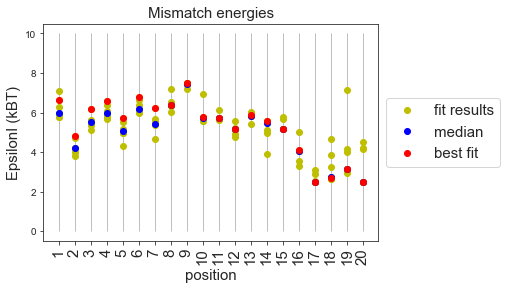

In [7]:
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,21),energies_low_chi[i][5:25],'yo',label='fit results')

plot2, = plt.plot(range(1,21),median_energies[5:25],'bo',label='median')
plot3, = plt.plot(range(1,21),energies[np.argmin(chi_squared)][5:25],'ro',label='best fit')
#plot4, = plt.plot(range(1,21),parameters[20:40],'ko',label='actual values')
plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('EpsilonI (kBT)',fontsize=15)
plt.title('Mismatch energies',fontsize=15)
plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');

## Rates

[-3.07340404 -0.68633178  0.16051622 -0.02403019]
[-3.06719311 -0.76810583  0.13907091  3.78865798]
[-3.0677969  -0.7676319   0.15198331  1.46641783]
[-3.08614646 -0.38853164  0.17934165 -0.54425233]
[-3.0599934  -0.76710832  0.08108744  1.4938621 ]
[-3.06602394 -0.76133641  0.09202393  1.36308267]
[-3.07358967 -0.64470347 -0.05140413  0.04423201]


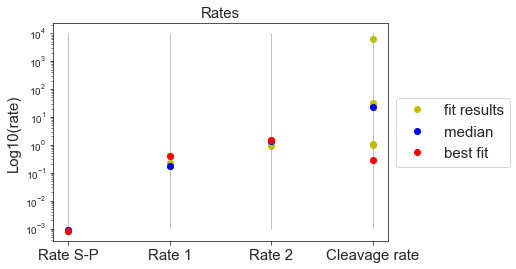

In [8]:
plt.figure()
for i in range(len(energies_low_chi)):
    plot1, = plt.plot(range(1,len(rates_low_chi[i])+1),rates_low_chi[i],'yo',label='fit results')
    print np.log10(rates_low_chi[i])
    
plot2, = plt.plot(range(1,len(rates_low_chi[i])+1),median_rates,'bo',label='median')
plot3, = plt.semilogy(range(1,len(rates_low_chi[i])+1),rates[np.argmin(chi_squared)],'ro',label='best fit')

plt.legend(handles=[plot1,plot2,plot3],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.ylabel('Log10(rate)',fontsize=15)
plt.title('Rates',fontsize=15)
plt.vlines(range(1,len(rates_low_chi[i])+1),10**-3,10**4,color='grey',linewidth=0.5);
plt.xticks(range(1,len(rates_low_chi[i])+1),['Rate S-P','Rate 1','Rate 2','Cleavage rate'],fontsize=15);

## Landscape

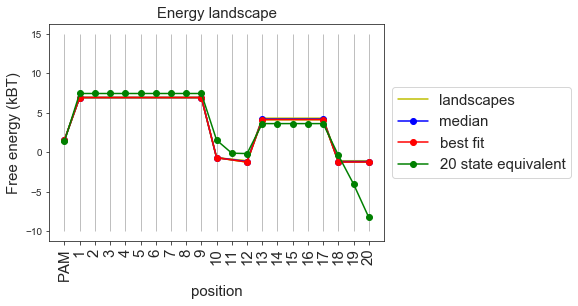

In [96]:
landscapes = np.zeros([len(energies_low_chi),9])

plt.figure()
for i in range(len(energies_low_chi)):
    epsilontemp = np.cumsum(np.append(energies[i][0], -energies[i][1:5]))
    epsilontemp = np.append(epsilontemp[0],np.append([epsilontemp[0] + energies_low_chi[i][5],epsilontemp[0] + energies_low_chi[i][5]],epsilontemp[1:]))
    epsilontemp = np.append(epsilontemp[0:5],np.append([epsilontemp[4] + energies_low_chi[i][6],epsilontemp[4] + energies_low_chi[i][6]],epsilontemp[5:]))
    plot1, = plt.plot([0,1,9,10,12,13,17,18,20],epsilontemp,'y-',label='landscapes')
    landscapes[i][:] = epsilontemp

medianls = np.median(landscapes, 0)
    
plot2, = plt.plot([0,1,9,10,12,13,17,18,20],medianls,'b-o', label='median') 

epsilontemp = np.cumsum(np.append(energies[np.argmin(chi_squared)][0], -energies[np.argmin(chi_squared)][1:5]))
epsilontemp = np.append(epsilontemp[0],np.append([epsilontemp[0] + energies[np.argmin(chi_squared)][5],epsilontemp[0] + energies[np.argmin(chi_squared)][5]],epsilontemp[1:]))
epsilontemp = np.append(epsilontemp[0:5],np.append([epsilontemp[4] + energies[np.argmin(chi_squared)][6],epsilontemp[4] + energies[np.argmin(chi_squared)][6]],epsilontemp[5:]))
plot3, = plt.plot([0,1,9,10,12,13,17,18,20],epsilontemp,marker='o',color='red',label='best fit')

landscape = np.zeros(21)
landscape[0] = 1.389248 #PAM Boyle, minus PAM Boyle :)
landscape[1:10] = np.ones(9)*7.44538973 #median height
landscape[10:13] = [1.547533, -0.105180, -0.153215] #well defined dip, from Boyle
landscape[13:18] = np.ones(5)*3.6374928 #median height
landscape[18:21] = [-0.361180,-4.009278,-8.223548] #well defined second dip, from Boyle

plot4, = plt.plot(range(0,21),landscape,marker='o',color='green',label='20 state equivalent')

plt.legend(handles=[plot1,plot2,plot3,plot4],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
plt.xlabel('position',fontsize=15)
plt.ylabel('Free energy (kBT)',fontsize=15)
plt.title('Energy landscape',fontsize=15)
plt.vlines(range(0,21),-10,15,color='grey',linewidth=0.5);
plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');